In [41]:
import numpy as np
import pandas as pd
import scipy as sci
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('vader_lexicon')

plt.style.use("Solarize_Light2")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/titanjuels/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/titanjuels/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/titanjuels/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/titanjuels/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/titanjuels/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


This is my sentiment analysis project, i will be using the amazon fine food dataset

In [2]:
df = pd.read_csv("data/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Check its clean

In [35]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [3]:
df.shape

(568454, 10)

A little too large for my liking, so we'll use the first 5000

In [4]:
df = df.head(5000)

In [5]:
df.shape

(5000, 10)

<Axes: title={'center': 'Rating Frequencies'}, xlabel='Score'>

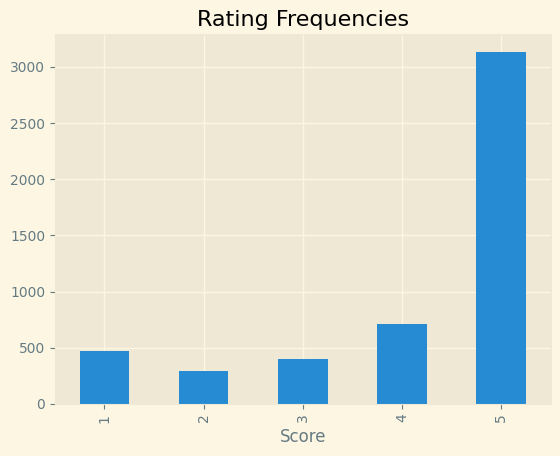

In [6]:
# EDA STEP
df["Score"].value_counts().sort_index().plot(kind='bar', title='Rating Frequencies')

In [7]:
# Messing with NLTK
ex = df['Text'][350]
print(ex)

'These chocolate covered espresso beans are wonderful!  The chocolate is very dark and rich and the "bean" inside is a very delightful blend of flavors with just enough caffine to really give it a zing.'

In [8]:
# i would expect positive sentiment and solid 'helpfulness'
tokens = nltk.word_tokenize(ex)
tokens[:10]

['These',
 'chocolate',
 'covered',
 'espresso',
 'beans',
 'are',
 'wonderful',
 '!',
 'The',
 'chocolate']

In [9]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('These', 'DT'),
 ('chocolate', 'NN'),
 ('covered', 'VBD'),
 ('espresso', 'JJ'),
 ('beans', 'NNS'),
 ('are', 'VBP'),
 ('wonderful', 'JJ'),
 ('!', '.'),
 ('The', 'DT'),
 ('chocolate', 'NN')]

In [10]:
chunked = nltk.chunk.ne_chunk(tagged)
chunked.pprint()

(S
  These/DT
  chocolate/NN
  covered/VBD
  espresso/JJ
  beans/NNS
  are/VBP
  wonderful/JJ
  !/.
  The/DT
  chocolate/NN
  is/VBZ
  very/RB
  dark/JJ
  and/CC
  rich/JJ
  and/CC
  the/DT
  ``/``
  bean/NN
  ''/''
  inside/NN
  is/VBZ
  a/DT
  very/RB
  delightful/JJ
  blend/NN
  of/IN
  flavors/NNS
  with/IN
  just/RB
  enough/RB
  caffine/NN
  to/TO
  really/RB
  give/VB
  it/PRP
  a/DT
  zing/NN
  ./.)


### VADER
I will now attempt to use VADER scoring in order to rate the scores. A problem with this appraoch compared to BERT is that VADER doesn't recognize relationships between words (i.e. context). So, smth like, "I really really really really don't like this product!", might be rated as a positive sentiment, as 'really' may be determined as positive, so 4 positives and 1 negative might be positive overall. You get the picture.

But this seems like an approach i might come up with, so i want to try it.

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I am super happy!")

{'neg': 0.0, 'neu': 0.112, 'pos': 0.888, 'compound': 0.8356}

In [12]:
# Out of curiousity
sia.polarity_scores("I really really really really don't like this product!")

{'neg': 0.296, 'neu': 0.704, 'pos': 0.0, 'compound': -0.4486}

In [13]:
# im also curious, i'll use a sentence i consider to be neutral/positive
sia.polarity_scores("It's not the worst thing ever")

{'neg': 0.0, 'neu': 0.603, 'pos': 0.397, 'compound': 0.5096}

Fortunately its not as naive as what i had imagined, but lets continue.

In [14]:
sia.polarity_scores(ex)

{'neg': 0.0, 'neu': 0.715, 'pos': 0.285, 'compound': 0.9177}

In [33]:
# Now I'll go through the entire dataset, creating a new dataframe with all the scores, corresponding to that id
scored_df = df['Text'].apply(sia.polarity_scores).apply(pd.Series)
scored_df['Id'] = df['Id']
scored_df = scored_df[['Id', 'neg', 'neu', 'pos', 'compound']]
scored_df.head()

,Id,neg,neu,pos,compound
0,1,0.000,0.695,0.305,0.9441
1,2,0.138,0.862,0.000,-0.5664
2,3,0.091,0.754,0.155,0.8265
3,4,0.000,1.000,0.000,0.0000
4,5,0.000,0.552,0.448,0.9468


In [34]:
# Now we can easily index from the df to find the score for that comment in the 'scored_df'
vader_df = scored_df.merge(df, how='left')
vader_df.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


We'll assume score of 5 means more positive 'Text', and score of 1 means more negative 'Text'.

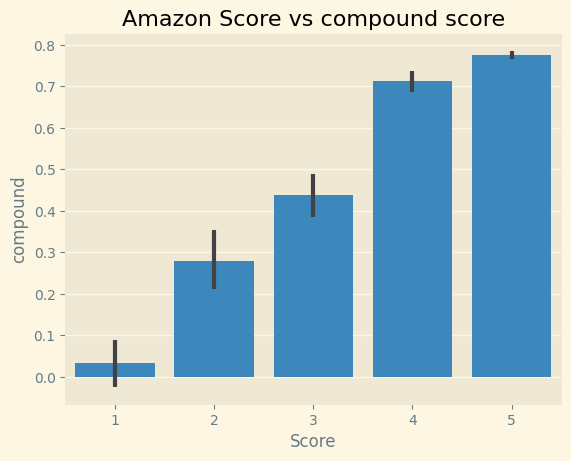

In [42]:
ax1 = sns.barplot(vader_df, x='Score', y='compound')
ax1.set_title("Amazon Score vs compound score")
plt.show()

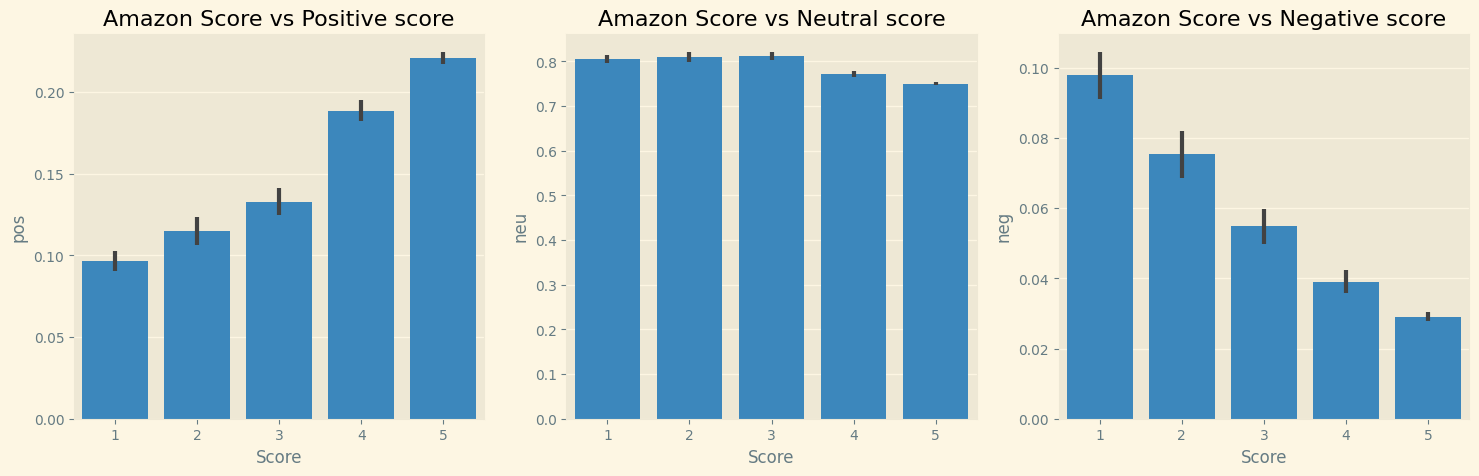

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))
sns.barplot(vader_df, x='Score', y='pos', ax=axs[0])
sns.barplot(vader_df, x='Score', y='neu', ax=axs[1])
sns.barplot(vader_df, x='Score', y='neg', ax=axs[2])
axs[0].set_title("Amazon Score vs Positive score")
axs[1].set_title("Amazon Score vs Neutral score")
axs[2].set_title("Amazon Score vs Negative score")
plt.show()

We can see it follows the expected trend, generally more positives as the review gets higher, and less negatives as the review score increses. Neutrality is somewhat insignificant.

### BERT MODEL
I will now try to implement using transformers through the BERT model and I will compare the performance.